In [1]:
# 1. Install the API Client (If you haven't already done step 1)
!pip install kaggle

# 2. Make the directory Kaggle expects
!mkdir -p ~/.kaggle

# 3. Copy the uploaded kaggle.json file into the correct directory
!cp kaggle.json ~/.kaggle/

# 4. Set secure permissions on the file (Required by Kaggle)
!chmod 600 ~/.kaggle/kaggle.json

# 5. Download the dataset (This is step 3 in your file)
!kaggle datasets download -d moodrammer/handdrawn-circuit-schematic-components

# 6. Unzip the dataset (This is step 4 in your file)
!unzip -q handdrawn-circuit-schematic-components.zip


Dataset URL: https://www.kaggle.com/datasets/moodrammer/handdrawn-circuit-schematic-components
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
  0% 0.00/4.44M [00:00<?, ?B/s]
100% 4.44M/4.44M [00:00<00:00, 1.14GB/s]


In [4]:
# Cell 1: Setup and Data Loading (CORRECTED)

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os

# Define paths to your dataset
# IMPORTANT: Adjust 'path/to/your/dataset' to the actual path where you've extracted your Kaggle dataset
DATASET_PATH = '/content/SolvaDataset_200_v3'

# Define image dimensions and batch size
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 32

# Load data using ImageDataGenerator for augmentation and grayscale conversion
# The color_mode argument IS NOT used here (it caused the TypeError)
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values to [0, 1]
    validation_split=0.2, # 20% of data will be used for validation
    rotation_range=10, # Slight rotations
    width_shift_range=0.1, # Slight horizontal shifts
    height_shift_range=0.1, # Slight vertical shifts
    shear_range=0.1, # Shear transformations
    zoom_range=0.1, # Zoom in/out
    horizontal_flip=True, # Random horizontal flips
    fill_mode='nearest', # Strategy for filling in new pixels
    # color_mode='grayscale' <-- THIS LINE WAS THE ERROR!
)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale', # <-- CORRECT PLACEMENT
    class_mode='categorical', # For multi-class classification
    subset='training',
    seed=42
)

# Validation data generator
validation_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale', # <-- CORRECT PLACEMENT
    class_mode='categorical',
    subset='validation',
    seed=42
)

# Get class names (e.g., 'resistor', 'capacitor')
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)
print(f"Detected classes: {class_names}")
print(f"Number of classes: {num_classes}")

print(f"Number of training samples: {train_generator.samples}")
print(f"Number of validation samples: {validation_generator.samples}")

Found 2367 images belonging to 15 classes.
Found 585 images belonging to 15 classes.
Detected classes: ['Ammeter', 'ac_src', 'battery', 'cap', 'curr_src', 'dc_volt_src_1', 'dc_volt_src_2', 'dep_curr_src', 'dep_volt', 'diode', 'gnd_1', 'gnd_2', 'inductor', 'resistor', 'voltmeter']
Number of classes: 15
Number of training samples: 2367
Number of validation samples: 585


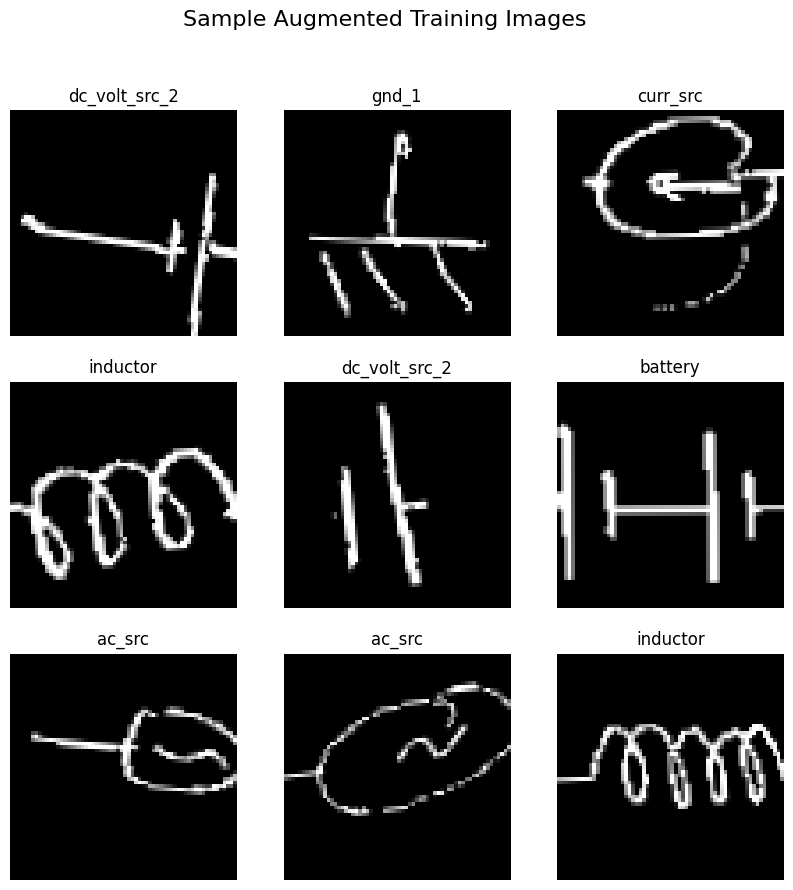

In [5]:
# Cell 2: Visualize Augmented Data

# Get a batch of training images and labels
sample_images, sample_labels = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # The image is already grayscale with 1 channel, so squeeze it for plotting
    plt.imshow(sample_images[i].squeeze(), cmap='gray')
    # Decode the one-hot encoded label back to a class name
    plt.title(class_names[np.argmax(sample_labels[i])])
    plt.axis("off")
plt.suptitle("Sample Augmented Training Images", fontsize=16)
plt.show()

In [6]:
# Cell 3: Define and Compile the CNN Model

# Clear any previous model sessions
tf.keras.backend.clear_session()

# Initialize the Sequential model
model = models.Sequential()

# 1. Convolutional Block 1
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

# 2. Convolutional Block 2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

# 3. Convolutional Block 3
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

# 4. Flattening
# Convert the 3D feature maps to 1D feature vectors
model.add(layers.Flatten())

# 5. Dense Layers (Classifier)
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
# Output layer: uses 'softmax' for multi-class classification
model.add(layers.Dense(num_classes, activation='softmax'))

# Model Summary
model.summary()

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', # Suitable for multi-class classification
    metrics=['accuracy']
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         7,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,463,119 (9.40 MB)

 Trainable params: 2,461,647 (9.39 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [8]:
# Cell 4: Train the Model (EarlyStopping Removed)

# Define the number of epochs
EPOCHS = 50

# The early_stopping callback is removed. The model will run for the full 50 epochs.

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    # callbacks=[early_stopping] <-- This line is removed
)

print("\nTraining complete.")

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.4395 - loss: 1.8999 - val_accuracy: 0.0677 - val_loss: 5.9717
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4062 - loss: 1.7352 - val_accuracy: 0.0660 - val_loss: 5.9734
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.5446 - loss: 1.3371 - val_accuracy: 0.1528 - val_loss: 6.0827
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6250 - loss: 1.1143 - val_accuracy: 0.1389 - val_loss: 6.1067
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.6057 - loss: 1.2032 - val_accuracy: 0.1059 - val_loss: 7.4367
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6250 - loss: 1.4027 - val_accuracy: 0.0868 - val_loss: 7.4324
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.6473 - loss: 1.0148 - val_accuracy: 0.1128 - val_loss: 5.8770
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7188 - loss: 0.7807 - val_accuracy: 0.0955 - val_

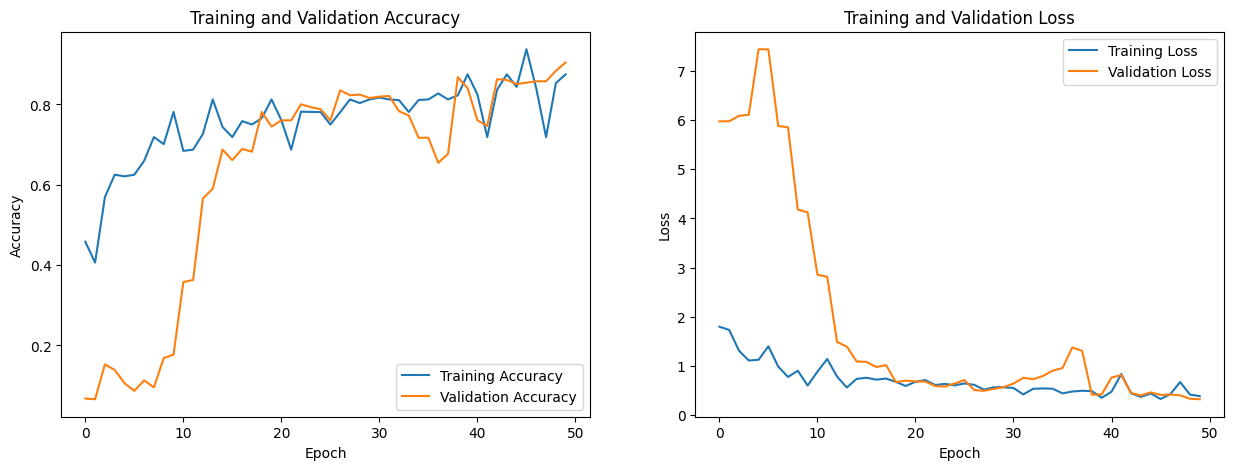

In [9]:
# Cell 5: Visualize Training History

# Get the history data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(15, 5))

# Plot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

In [10]:
# Cell 6: Evaluate Model and Generate Classification Report (F1-score, Precision, Recall)

from sklearn.metrics import classification_report, confusion_matrix

# 1. Reset the validation generator to ensure predictions start from the beginning
# This is crucial for correct alignment of predictions and true labels
validation_generator.reset()

# 2. Get predictions on the validation data
# Use verbose=0 to suppress output during prediction
print("Generating predictions on validation set...")
Y_pred = model.predict(validation_generator, steps=validation_generator.samples // BATCH_SIZE + 1, verbose=0)

# 3. Convert predictions from probabilities (one-hot) to class indices
y_pred_classes = np.argmax(Y_pred, axis=1)

# 4. Get true labels from the generator
# The generator's 'classes' attribute contains the true class indices
y_true = validation_generator.classes

# Since the generator might not yield all samples if steps is limited,
# we need to truncate y_true to match the number of predictions
y_true = y_true[:len(y_pred_classes)]

# 5. Generate the Classification Report
print("\n--- Classification Report (Precision, Recall, F1-Score) ---")
report = classification_report(
    y_true,
    y_pred_classes,
    target_names=class_names,
    digits=4,
    zero_division='warn' # Handles cases where a class has no predictions
)
print(report)

# 6. Optional: Generate and display the Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("\n--- Confusion Matrix (Top 5x5 if many classes) ---")
# Display a part of the matrix if there are too many classes
if num_classes > 5:
    print(cm[:5, :5])
else:
    print(cm)

Generating predictions on validation set...

--- Classification Report (Precision, Recall, F1-Score) ---
               precision    recall  f1-score   support

      Ammeter     0.0250    0.0250    0.0250        40
       ac_src     0.0682    0.0769    0.0723        39
      battery     0.0909    0.0750    0.0822        40
          cap     0.1000    0.1250    0.1111        40
     curr_src     0.0571    0.0500    0.0533        40
dc_volt_src_1     0.1111    0.1026    0.1067        39
dc_volt_src_2     0.1053    0.1026    0.1039        39
 dep_curr_src     0.0513    0.0513    0.0513        39
     dep_volt     0.0571    0.0513    0.0541        39
        diode     0.0263    0.0250    0.0256        40
        gnd_1     0.0278    0.0278    0.0278        36
        gnd_2     0.0750    0.0769    0.0759        39
     inductor     0.0556    0.0526    0.0541        38
     resistor     0.0500    0.0541    0.0519        37
    voltmeter     0.1556    0.1750    0.1647        40

     accuracy

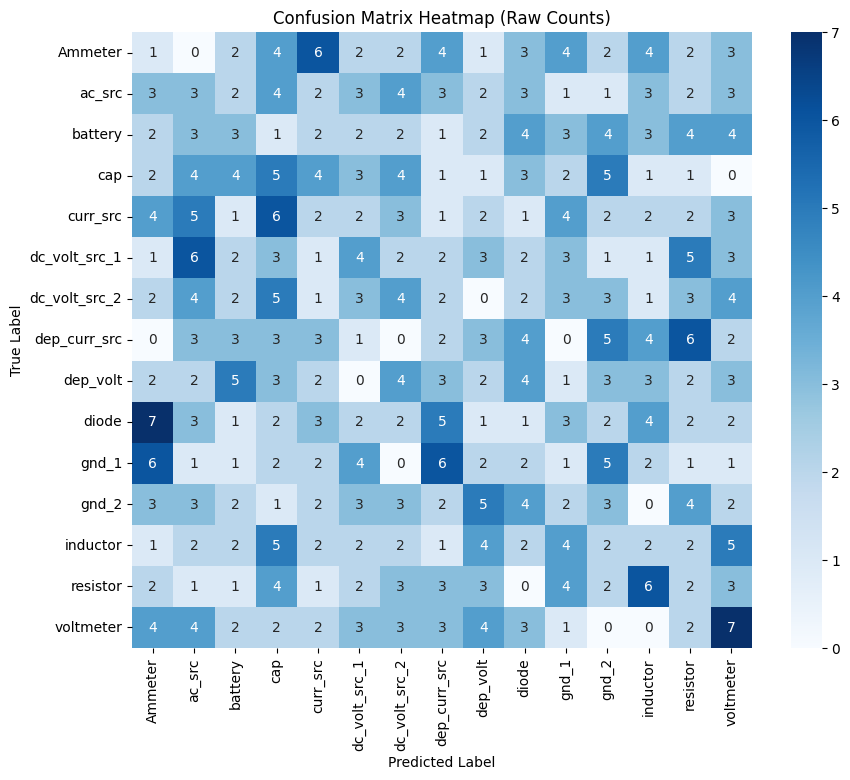

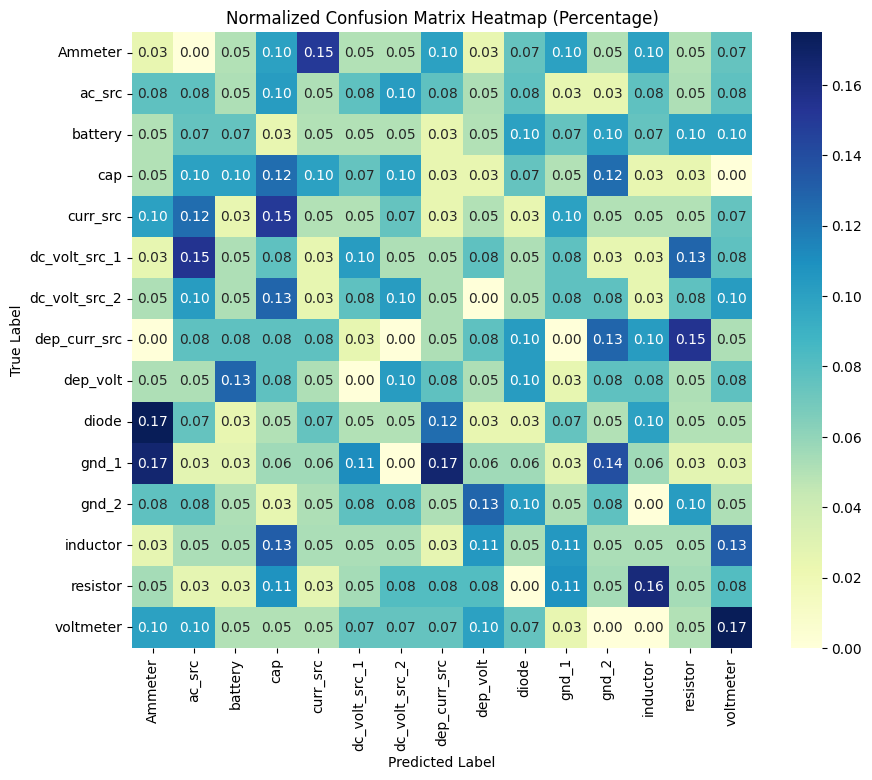

In [13]:
# Cell 7: Visualize Confusion Matrix Heatmap

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Check if cm and class_names are available from Cell 6
if 'cm' not in globals() or 'class_names' not in globals():
    print("Error: Please run Cell 6 (Evaluation) first to generate the Confusion Matrix (cm) and class names.")
else:
    # --- 1. Raw Count Confusion Matrix Heatmap ---
    plt.figure(figsize=(10, 8))

    # Create the heatmap
    sns.heatmap(
        cm,
        annot=True,              # Show the number in each cell
        fmt='d',                 # Format as an integer (digit)
        cmap='Blues',            # Color map (you can use 'viridis', 'YlGnBu', etc.)
        xticklabels=class_names, # Labels for the x-axis (Predicted classes)
        yticklabels=class_names, # Labels for the y-axis (True classes)
        cbar=True                # Show the color bar
    )

    # Add labels and title
    plt.title('Confusion Matrix Heatmap (Raw Counts)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # --- 2. Normalized Confusion Matrix Heatmap (Optional but highly recommended) ---
    # Normalizing the matrix helps show performance as a percentage of the true class size.
    # Divide each row by the sum of the row to get percentages
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt='.2f',               # Format as a float with 2 decimal places (percentage)
        cmap='YlGnBu',
        xticklabels=class_names,
        yticklabels=class_names,
        cbar=True
    )
    plt.title('Normalized Confusion Matrix Heatmap (Percentage)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

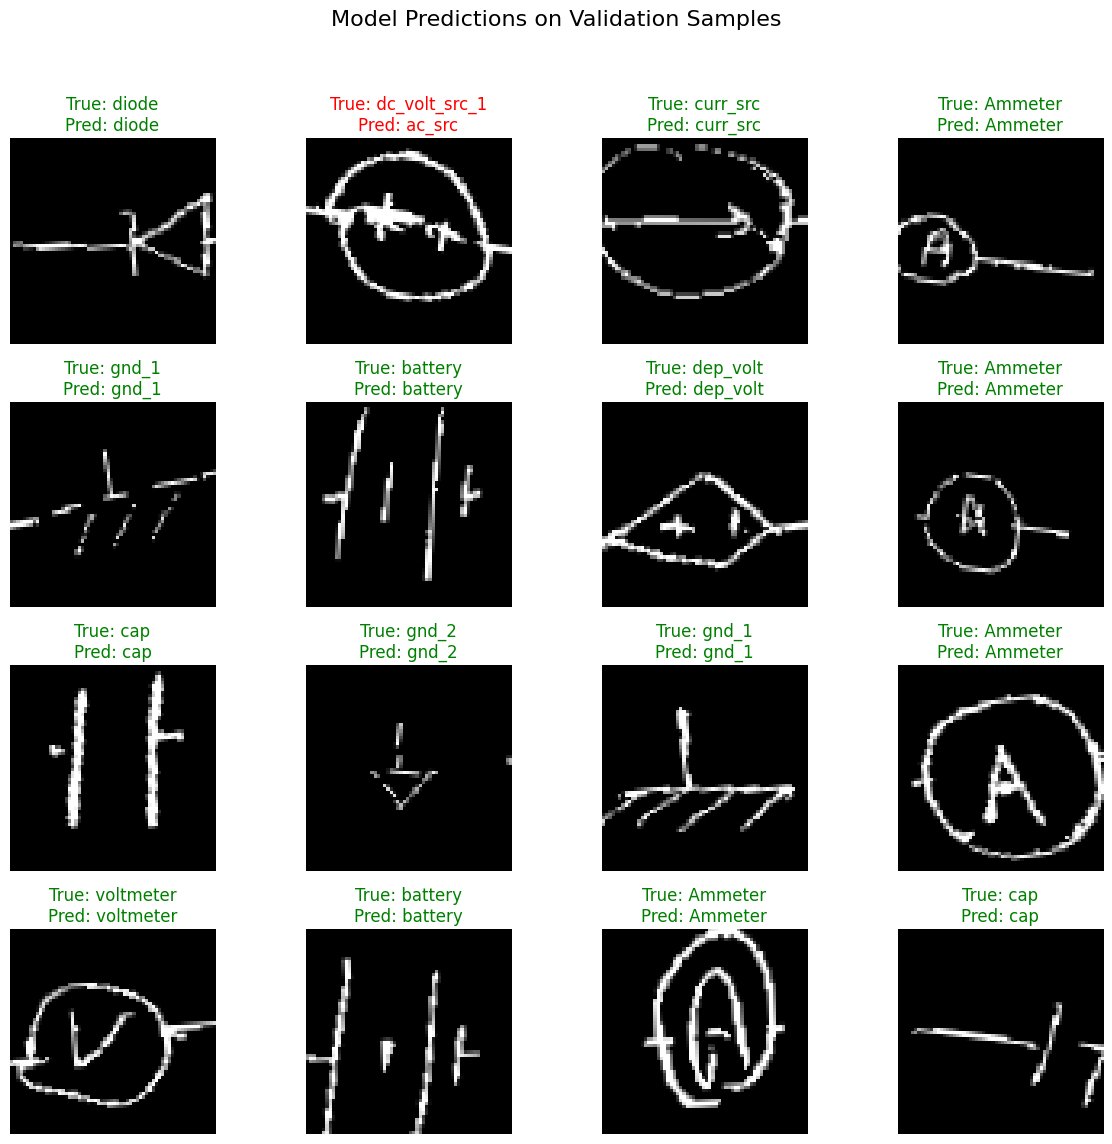


Green title = Correct Prediction
Red title = Incorrect Prediction (Misclassification)


In [11]:
# Cell 7: Visualize Sample Predictions

# Get a fresh batch from the validation set
# We use 'next(validation_generator)' to get a new set of data
sample_val_images, sample_val_labels_one_hot = next(validation_generator)

# Make predictions on this batch
predictions_one_hot = model.predict(sample_val_images, verbose=0)

# Convert one-hot labels to class names/indices
predicted_classes = np.argmax(predictions_one_hot, axis=1)
true_classes = np.argmax(sample_val_labels_one_hot, axis=1)

# Plot the results
plt.figure(figsize=(12, 12))
plt.suptitle("Model Predictions on Validation Samples", fontsize=16)

# Iterate through the first 16 images in the batch
for i in range(16):
    if i >= len(sample_val_images):
        break

    ax = plt.subplot(4, 4, i + 1)

    # Image is grayscale (64, 64, 1), so squeeze it to (64, 64) for display
    plt.imshow(sample_val_images[i].squeeze(), cmap='gray')

    # Determine color based on correctness
    is_correct = predicted_classes[i] == true_classes[i]
    title_color = 'green' if is_correct else 'red'

    # Create the label string
    true_label = class_names[true_classes[i]]
    predicted_label = class_names[predicted_classes[i]]

    title_text = f"True: {true_label}\nPred: {predicted_label}"

    plt.title(title_text, color=title_color)
    plt.axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()

print("\nGreen title = Correct Prediction")
print("Red title = Incorrect Prediction (Misclassification)")

In [14]:
# Cell 8: Save the Model

MODEL_SAVE_PATH = 'hand_drawn_circuit_cnn_model.h5'

# Save the entire model (architecture, weights, and optimizer state)
try:
    model.save(MODEL_SAVE_PATH)
    print(f"Model successfully saved to: {MODEL_SAVE_PATH}")

    # Optional: Save the class names as a separate file (important for deployment)
    with open('class_names.txt', 'w') as f:
        for item in class_names:
            f.write("%s\n" % item)
    print("Class names saved to: class_names.txt")

except Exception as e:
    print(f"Error saving model: {e}")

# To load the model later:
# loaded_model = tf.keras.models.load_model(MODEL_SAVE_PATH)

Model successfully saved to: hand_drawn_circuit_cnn_model.h5
Class names saved to: class_names.txt


In [29]:
# Cell 9: Create and Launch the UI with Image Upload and Webcam (FINAL FIX)

import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image

# --- 1. Load Model and Class Names (No Change) ---

MODEL_SAVE_PATH = '/content/hand_drawn_circuit_cnn_model.h5'

try:
    # Use compile=False for robustness during loading
    loaded_model = tf.keras.models.load_model(MODEL_SAVE_PATH, compile=False)
    with open('class_names.txt', 'r') as f:
        class_names = [line.strip() for line in f]
    print("Model and class names loaded successfully for UI creation.")
except Exception as e:
    print(f"FATAL ERROR: Could not load model or class names. Details: {e}")
    loaded_model = None

IMG_HEIGHT = 64
IMG_WIDTH = 64

# --- 2. Define the Prediction Function (Same Robust Logic) ---

def predict_symbol(img_np_array):
    """
    Handles input from gr.Image (uploaded images or webcam).
    """
    if loaded_model is None:
        return {"Model Not Loaded Error": 1.0}

    if img_np_array is None:
        return {"Please upload an image or use the webcam": 1.0}

    try:
        # --- Preprocessing Steps ---
        img_pil = Image.fromarray(img_np_array.astype(np.uint8))
        img_gray = img_pil.convert('L')
        img_resized = img_gray.resize((IMG_WIDTH, IMG_HEIGHT))
        img_array = np.array(img_resized, dtype='float32')

        # 5. Invert and Normalize

        img_array /= 255.0

        # 6. Explicit Shape Check and Expansion: (64, 64) -> (1, 64, 64, 1)
        if img_array.ndim == 2:
            img_array_final = np.expand_dims(img_array, axis=-1)
            img_array_final = np.expand_dims(img_array_final, axis=0)
        else:
            return {f"Shape Error: Expected (64, 64), got {img_array.shape}": 1.0}

        # 7. Make prediction
        predictions = loaded_model.predict(img_array_final, verbose=0)[0]

        # 8. Format results
        confidences = {class_names[i]: float(predictions[i]) for i in range(len(class_names))}

        return confidences

    except Exception as e:
        return {f"Prediction Failed": 1.0, f"Detail: {str(e)}": 0.0}

# --- 3. Create the Gradio Interface using Blocks (FIXED Input Component) ---

if 'loaded_model' in globals() and loaded_model is not None:

    with gr.Blocks(title="Circuit Symbol Recognizer") as demo:
        gr.Markdown(
            """
            # Circuit Symbol Recognizer ⚡
            **Upload an image or capture one with your webcam** to classify the circuit symbol. Click **Predict** to classify it.
            """
        )
        with gr.Row():
            with gr.Column(scale=1):
                # FIX: Removed 'sketch' from sources list based on the error message
                image_input = gr.Image(
                    type="numpy",
                    label="Upload Image or Use Webcam",
                    height=400,
                    width=400,
                    # --- FIXED SOURCES LIST ---
                    sources=["upload", "webcam", "clipboard"]
                )
                predict_btn = gr.Button("🚀 Predict Symbol")
                clear_btn = gr.Button("🔄 Clear Input")

            with gr.Column(scale=2):
                label_output = gr.Label(
                    num_top_classes=len(class_names),
                    label="Prediction and Confidence"
                )

        # --- 4. Define Event Listener ---
        predict_btn.click(
            fn=predict_symbol,
            inputs=image_input,
            outputs=label_output
        )

        # Clear button functionality
        clear_btn.click(
            fn=lambda: (None, {cls: 0.0 for cls in class_names}),
            outputs=[image_input, label_output],
            api_name=False
        )

    print("\nLaunching Gradio Interface...")
    demo.launch(share=True)

Model and class names loaded successfully for UI creation.

Launching Gradio Interface...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://39813db2c9ea9eb2fa.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
